# Data analysis of server(s) tasks submission and runtimes

## Overview

In this notebook, the "Job Arrival Process" \[1], ie. the Arrival Rate, Inter-arrival Time, and Actual Runtime is analysed.  Additionally, the job modelling characteristics Bag Of Tasks, Burstiness, and Periodicity is also explored \[1].

## Problems with the trace data

When examining the `job_submission_time` and `the_runtime_of_each_task` fields of the trace, the time increment is not specified. This information is important to determine to accurately interperet the data. When looking at the source for the Yahoo! workload trace \[2], the  trace comes from a cluster of approximately 2000 machines at Yahoo! (YH trace), covers three weeks in late February 2009 and early March 2009, and contains around 30,000 jobs. It also details that the running time is in task-seconds of map and reduce functions. Thus, for the `the_runtime_of_each_task` field, we can make the assumption that the floating point number is in seconds. If we make the assumption that the `job_submission_time`, we would expect the last job submission time to be close to the number of seconds in 3 weeks, which is `60 x 60 x 24 x 7 x 3 = 1814400`. When looking at the last job record in the Yahoo! trace `YH.tr`, the `job_submission_time` is 181440, thus we can make the assumption that the submission time is measure in tens of seconds.

Unfortunately, when doing the same thing for the Facebook trace `FB.tr`, the last job record has a submit time of 388171, this is vastly different to the number of seconds in 6 months, which is approximately `60 x 60 x 24 x 30 x 6 = 15552000`. It also shares no regular pattern to the last job submit time. This issue of unknown time units must be resolved before analysing the Facebook trace, and potentially the other traces.

*\[1] F. Ian, "WORKLOAD CHARACTERISATION FOR CLOUD RESOURCE MANAGEMENT," School of Engineering Macquarie University, 2020, pp. 4-7.*
 
*\[2] Y. Chen, A. Ganapathi, R. Griffith and R. Katz, "The Case for Evaluating MapReduce Performance Using Workload Suites," 2011 IEEE 19th Annual International Symposium on Modelling, Analysis, and Simulation of Computer and Telecommunication Systems, 2011, pp. 390-399, doi: 10.1109/MASCOTS.2011.12.*

## Importing the data

The first step is to import the data from the `tasks.csv` file. This file is generated from the `*.tr` trace files using the preprocessing script `process-trace.sh`. 

The `pandas` library is used to import the CSV file as a Dataframe. Pandas is a data science tool used for exploring and manipulating data. The `numpy` library is also imported to be used in conjuction with `pandas` to manipulate the Dataframe.

In [1]:
import numpy as np
import pandas as pd

with open('preprocessing/tasks.csv') as file:
    data = pd.read_csv(file)

data

,job_submission_time,runtime_of_task
0,7.527,6.441536
1,7.527,12.973575
2,7.527,17.270219
3,7.527,15.555188
4,7.527,25.908657
...,...,...
968330,181440.000,8.889653
968331,181440.000,6.559036
968332,181440.000,9.949698
968333,181440.000,5.361862


In [2]:
data.describe()

,job_submission_time,runtime_of_task
count,968335.000000,968335.000000
mean,91914.793646,642.903648
std,51837.227473,1821.033718
min,7.527000,0.000015
25%,45893.400000,12.958736
50%,93491.100000,63.893252
75%,136198.000000,629.916897
max,181440.000000,21250.869152


## Inter-Arrival Time of Tasks

Below is a boxplot displaying the distribution of Inter-Arrival Time of Tasks (excluding Bag of Tasks, i.e. an inter-arrival time of 0).

51        7.565
85        7.558
109       7.354
114       7.421
117       7.421
          ...  
968201    7.000
968282    8.000
968289    7.000
968315    8.000
968316    7.000
Name: job_submission_time, Length: 24261, dtype: float64


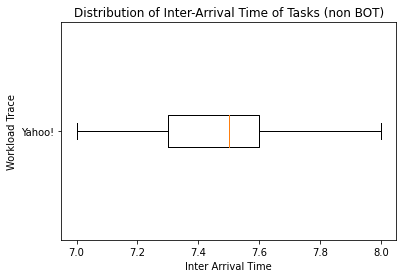

In [3]:
from matplotlib import pyplot as plt

interArrival = data['job_submission_time'].diff()
interArrival[0] = 0
interArrival = interArrival[interArrival > 0]

print(interArrival)

plt.boxplot(interArrival, vert=False, labels=["Yahoo!"], showfliers=True)
plt.xlabel("Inter Arrival Time")
plt.ylabel("Workload Trace")
plt.title("Distribution of Inter-Arrival Time of Tasks (non BOT)")
plt.show()

In [4]:
import scipy.stats
import fitDistribution as fd

fd.best_fit_distribution(interArrival)


('johnsonsb',
 (0.7221420497518202,
  0.18480053611803304,
  6.9999999999999885,
  1.0000000000088285),
 [{'alpha': {'loc': -1.5632819223535375,
    'scale': 239.3319382742668,
    'arg': (26.507751255721338,),
    'sse': 6208.778600501921}},
  {'anglit': {'loc': 7.489147424471753,
    'scale': 0.9079903117321388,
    'arg': (),
    'sse': 6209.005711433985}},
  {'arcsine': {'loc': 6.999999999999999,
    'scale': 1.0745937129595085,
    'arg': (),
    'sse': 5750.113661664189}},
  {'beta': {'loc': 6.999999999999999,
    'scale': 1.2394472980521583,
    'arg': (0.5607254713261383, 1.7717392349039587),
    'sse': 5667.10610340512}},
  {'betaprime': {'loc': -7.17825723611595,
    'scale': 10.261876911294863,
    'arg': (1434.6858896665099, 1004.4775131506549),
    'sse': 6213.5429499950615}},
  {'bradford': {'loc': 6.999999997471802,
    'scale': 1.0000000125005661,
    'arg': (1.0851867559883566,),
    'sse': 6166.679302645134}},
  {'burr': {'loc': -32.658620575683614,
    'scale': 37.42